# note: do evaluation in (N,C,L) format, this way the accuracy is better reflected, and we still get stel predictions over time

# TODO: historic average and need a map of time step to historic step...
- For each data division we extract all model-results and plot on ROC and PR curves as well as some cell plots
- The number of hours of the division should give an indication of cell plot scales 
- Separate model results and model metrics: allows for less disc space being used

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold
from models.model_result import ModelResult
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, TriangularMovingAverage, HistoricAverage

In [3]:
os.listdir("./data/processed")

['T6H-X850M-Y880M',
 'T24H-X85M-Y110M',
 'T24H-X850M-Y880M',
 'T24H-X425M-Y440M',
 'T12H-X850M-Y880M',
 'T1H-X1700M-Y1760M',
 'T3H-X850M-Y880M']

In [4]:
# todo add to utils
def get_time_step_from_data_folder(folder_name):
    """
    Also used to get the window on the cell plots
    """
    i = folder_name.find("H")
    if i < 0:
        return None
    return int(folder_name[1:i])

def get_historic_step_from_time_step(time_step):
    if time_step:
        return int(24/time_step)
a = map(get_time_step_from_data_folder, os.listdir("./data/processed"))
b = map(get_historic_step_from_time_step, a)
list(b)

[4, 1, 1, 1, 2, 24, 8]

In [5]:
conf_dict = {
    "seed": 3,
    "resume": False,
    "early_stopping": False,
    "use_cuda": False,
    "val_ratio": 0.1,
    "tst_ratio": 0.2,
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    "flatten_grid": True,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 10,
    "batch_size": 64,
    "dropout": 0,
    "shuffle": False,
    "num_workers": 6,
    "seq_len": 1,
    "top_k_cells": 50,
    "use_top_k_cells": True,
}

conf = BaseConf(conf_dict)

data_dim_str = 'T3H-X850M-Y880M'
data_path = f"./data/processed/{data_dim_str}/"
os.makedirs(data_path, exist_ok=True)

In [6]:
conf.top_k_cells

50

In [7]:
data_group = FlatDataGroup(data_path=data_path, conf=conf)

In [8]:
# taking only the first 300 of all crimes
crimes = data_group.crimes[:365, 0]

In [9]:
mean = crimes.mean(1).reshape(-1,1)
mean = mean/np.max(mean)*np.max(crimes)
stack = np.hstack([mean, crimes])

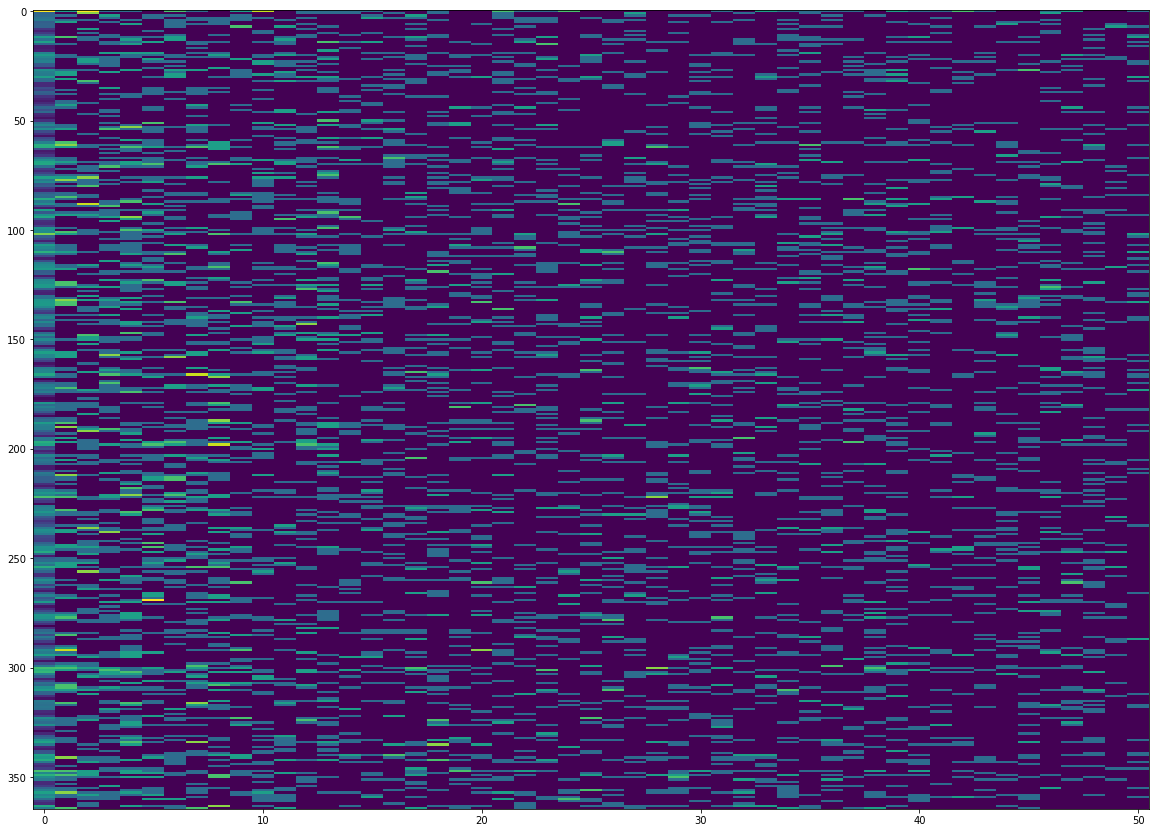

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(stack,aspect=.1,cmap='viridis')
plt.show()

In [26]:
model_results = []

Hawkes models incorporate the mean and the self exciting variables - when we train each cell on the data and 
l(k) = u + wet-t-1 - save the parameters in a grid and plot. Should show us how much the thing is influence.
Espetially the ratio between the average and the actual excitation.


#### Historic average model

In [27]:
time_step = get_historic_step_from_time_step(get_time_step_from_data_folder(data_dim_str))
print(f"using time step: {time_step}")

ha = HistoricAverage(step=time_step)
all_crimes = data_group.crimes[:,0]
tst_targets = data_group.testing_set.targets
all_crimes_ha = ha(all_crimes)
tst_crimes_ha = all_crimes_ha[-len(tst_targets):]

probas_pred = tst_crimes_ha.flatten()

N,_,L = tst_targets.shape
targets_shape = N,L
y_true = tst_targets.flatten()

thresh = best_threshold(y_true, probas_pred)
y_pred = np.copy(probas_pred)
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh] = 0

ha_model_result = ModelResult(model_name=f"HA {time_step}",
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=data_group.testing_set.t_range,
                                indices=None,
                                shape=targets_shape)

model_results.append(ha_model_result)

using time step: 8
(29200,), (29200,)
f1_score: 0.465533775748974 at index 9605, new threshold 0.06554048276566536


#### Mean of training data as future prediction

In [20]:
# Mean of training data as future prediction
trn_crimes = data_group.training_set.crimes

# only get the mean of the trn_set
crimes_mean = np.mean(trn_crimes[:,0],axis=0,keepdims=True)  # keep dims used to make scalar product easy
crimes_ones = np.ones_like(data_group.testing_set.targets)
y_pred_sparse = crimes_mean*crimes_ones
tst_targets = data_group.testing_set.targets

N,_,L = tst_targets.shape
targets_shape = N,L


y_pred_dense = y_pred_sparse

probas_pred = y_pred_dense.flatten()
y_true = tst_targets.flatten()
thresh = best_threshold(y_true, probas_pred)
y_pred = np.copy(probas_pred)
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh] = 0

mean_model_result = ModelResult(model_name="Train Mean",
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=data_group.testing_set.t_range,
                                indices=None,
                                shape=targets_shape)

model_results.append(mean_model_result)

f1_score: 0.4136729934763999 at index 5, new threshold 0.06435387613469125


#### Rolling mean of all data 

In [21]:
for window_len in [16]:
    for alpha in [0.1,0.5,3]:
        ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)
        all_crimes = data_group.crimes[:,0]
        tst_targets = data_group.testing_set.targets
        all_crimes_ma = ma(all_crimes)
        tst_crimes_ma = all_crimes_ma[-len(tst_targets):]

        N,_,L = tst_targets.shape
        targets_shape = N,L

        targets_dense = tst_targets

        y_pred_dense = tst_crimes_ma

        probas_pred = y_pred_dense.flatten()
        y_true = targets_dense.flatten()

        thresh = best_threshold(y_true, probas_pred)
        y_pred = np.copy(probas_pred)
        y_pred[y_pred >= thresh] = 1
        y_pred[y_pred < thresh] = 0

        ma_model_result = ModelResult(model_name=f"EMA window={window_len}, alpha={alpha}",
                                        y_true=y_true,
                                        y_pred=y_pred,
                                        probas_pred=probas_pred,
                                        t_range=data_group.testing_set.t_range,
                                        indices=None,
                                        shape=targets_shape)

        model_results.append(ma_model_result)

f1_score: 0.41291409625784714 at index 0, new threshold 0.0
f1_score: 0.41291409625784714 at index 0, new threshold 0.0
f1_score: 0.41291409625784714 at index 0, new threshold 0.0


#### Adding random noise to the predictions

In [23]:
for noise_std in [0.4,0.8]:
    tst_crimes = data_group.testing_set.targets  # only mask the targets as the outputs


    noise = noise_std*np.random.randn(*np.shape(tst_crimes))
    # should be a flip seeing that the class distribution is so skew

    y_pred_sparse = tst_crimes + noise
    targets_dense = data_group.testing_set.targets
    y_pred_dense = y_pred_sparse

    probas_pred = y_pred_dense.flatten()
    
    N,_,L = targets_dense.shape
    targets_shape = N,L
    
    y_true = targets_dense.flatten()
    thresh = best_threshold(y_true, probas_pred)
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    noise_model_result = ModelResult(model_name=f"Noise model std={noise_std}",
                                    y_true=y_true,
                                    y_pred=y_pred,
                                    probas_pred=probas_pred,
                                    t_range=data_group.testing_set.t_range,
                                    indices=None,
                                    shape=targets_shape) # shape should be targets - shape

    model_results.append(noise_model_result)

f1_score: 0.8307241356338686 at index 20742, new threshold 0.6335867182560445
f1_score: 0.5959965187119235 at index 19338, new threshold 0.6455413038391968



            Model Name: Noise model std=0.4
                ROC AUC:            0.9616050381703736
                Average Precision:  0.9121227121235531
                Accuracy:           0.9129794520547945
                MCC:                0.7722765822061225          
        

            Model Name: Noise model std=0.8
                ROC AUC:            0.8145882312195742
                Average Precision:  0.6257861057731251
                Accuracy:           0.761541095890411
                MCC:                0.4363225262807411          
        


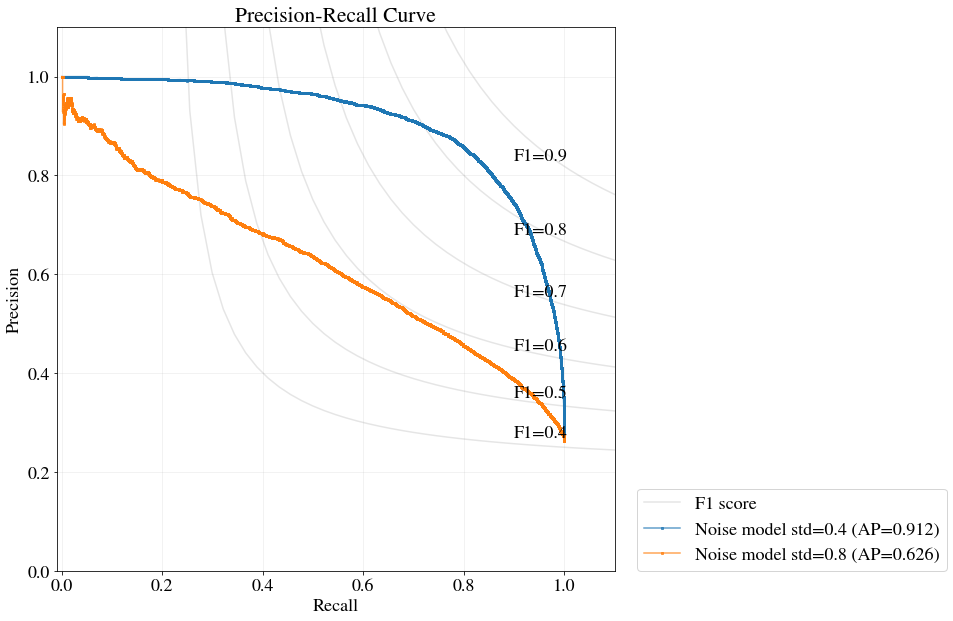

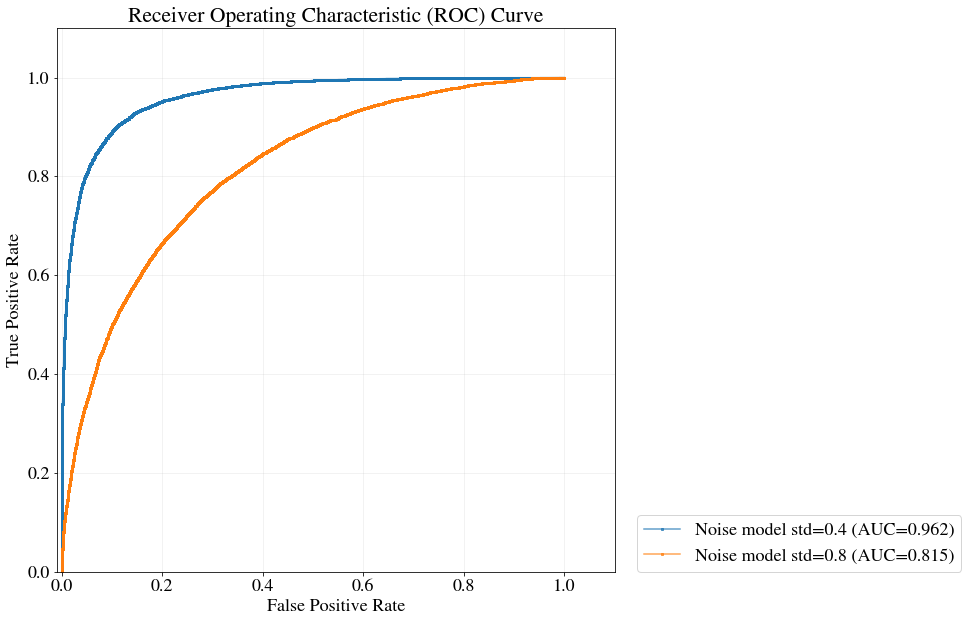

In [24]:
for result in model_results:
    print(result)

pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

In [25]:
# todo create function do unflatten y_true, y_probs, and probas_true
# use shape of the model and just rnp.reshape


In [131]:
# implement cell plotter
for result in model_results:
#     cell_plotter = CellPlotter(f"Cell wise plot {data_dim_str} - {result.model_name}")
    print(f"model name: {result.model_name}")
    print(f"result.y_true: {len(result.y_true)}")
    print(f"result.y_pred: {len(result.y_pred)}")
    print(f"result.probas_pred: {len(result.probas_pred)}")
    print()
    
    

#     cell_plotter.plot_predictions(y_true=result.y_true,
#                                   y_pred=result.y_pred,
#                                   probas_pred=result.probas_pred)
#     cell_plotter.show()
    
# consider doing a cell plot with colors and imshow - is visually more compelling    


model name: HA 4
result.y_true: 14600
result.y_pred: 14600
result.probas_pred: 14600

model name: Train Mean
result.y_true: 14600
result.y_pred: 14600
result.probas_pred: 14600

model name: EMA 16
result.y_true: 14600
result.y_pred: 14600
result.probas_pred: 14600

model name: Drop Out p(0.3)
result.y_true: 14600
result.y_pred: 14600
result.probas_pred: 14600

model name: Noise model std=0.4
result.y_true: 14600
result.y_pred: 14600
result.probas_pred: 14600

model name: Noise model std=0.8
result.y_true: 14600
result.y_pred: 14600
result.probas_pred: 14600

